
# Exercise 4 — Clustering in Python

**Dataset:** `toolo.csv`  
**Focus:** preprocessing, k-means (k=7), Sammon/MDS + distributions + silhouette, DBI model selection, and cluster interpretation via time series.

## Learning goals
By the end, you will be able to:
1. Choose and justify a similarity measure and preprocessing (standardization, min–max, vector-length normalization).
2. Run **K-means** and **Hierarchical** clustering and read **dendrograms**.
3. Evaluate cluster quality with **Davies–Bouldin index (DBI)** and **Silhouette**.
4. Visualize and interpret clusters with time series and distribution plots.
5. Communicate concise, domain-informed explanations of clusters.



## 0. Imports


In [1]:

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from sklearn.manifold import MDS

pd.set_option("display.max_columns", 60)
pd.set_option("display.width", 140)
RNG = 0



## 1. Load and split the data



Create two views as in the exercise:
- `data_for_clustering = data.iloc[:, 3:7]` (pollutants only)  
- `data_for_presentation = data.iloc[:, 3:]` (pollutants + weather)


In [2]:
data = pd.read_csv('toolo.csv')
data_for_clustering = data.iloc[:, 3:7].copy()
data_for_presentation = data.iloc[:, 3:].copy()

print("data_for_clustering:", data_for_clustering.shape)
print("data_for_presentation:", data_for_presentation.shape)

sample_size = 1000
if len(data_for_clustering) > sample_size:
    sample_idx = data_for_clustering.sample(n=sample_size, random_state=RNG).index
    sample_data_for_clustering = data_for_clustering.loc[sample_idx].sort_index()
    sample_data_for_presentation = data_for_presentation.loc[sample_idx].sort_index()
else:
    sample_data_for_clustering = data_for_clustering.copy()
    sample_data_for_presentation = data_for_presentation.copy()


data_for_clustering: (35064, 4)
data_for_presentation: (35064, 7)



## Task 1 — Transformations, K-means (k=7), and diagnostics


### 2.1 Normalization alternatives

In [3]:

std_scaler = StandardScaler()
norm_standard_cluster = pd.DataFrame(std_scaler.fit_transform(sample_data_for_clustering),
                                     columns=sample_data_for_clustering.columns)
norm_standard_present = pd.DataFrame(std_scaler.fit_transform(sample_data_for_presentation),
                                     columns=sample_data_for_presentation.columns)

mm_scaler = MinMaxScaler()
norm_minmax_cluster = pd.DataFrame(mm_scaler.fit_transform(sample_data_for_clustering),
                                   columns=sample_data_for_clustering.columns)
norm_minmax_present = pd.DataFrame(mm_scaler.fit_transform(sample_data_for_presentation),
                                   columns=sample_data_for_presentation.columns)

def l2_row_normalize(df):
    X = df.to_numpy(dtype=float)
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms[norms == 0.0] = 1.0
    return pd.DataFrame(X / norms, columns=df.columns, index=df.index)

norm_euclidean_cluster = l2_row_normalize(sample_data_for_clustering)
norm_euclidean_present = l2_row_normalize(sample_data_for_presentation)

norm_standard_cluster.head(3)


,NO2,O3,PM10,CO
0,0.074571,-0.545124,-0.343722,-0.618116
1,-0.554191,1.028132,-0.777668,-0.283048
2,0.954838,-0.769875,-0.525699,0.554621


### 2.2 K-means with 7 clusters (compare across transforms)

In [4]:

def kmeans_labels(X, k=7, n_init=100, random_state=RNG):
    km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
    y = km.fit_predict(X)
    return km, y

choices = {
    "standard": norm_standard_cluster,
    "minmax": norm_minmax_cluster,
    "rowL2": norm_euclidean_cluster,
}

scores = {}
for name, X in choices.items():
    km, y = kmeans_labels(X, k=7)
    sil = silhouette_score(X, y)
    dbi = davies_bouldin_score(X, y)
    scores[name] = {"silhouette": sil, "dbi": dbi}

pd.DataFrame(scores).T


,silhouette,dbi
standard,0.280415,1.044515
minmax,0.270329,1.091196
rowL2,0.374986,0.863567


### 2.3 Sammon’s mapping (fallback to metric MDS if `sammon.py` is missing)

c:\Users\steph\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


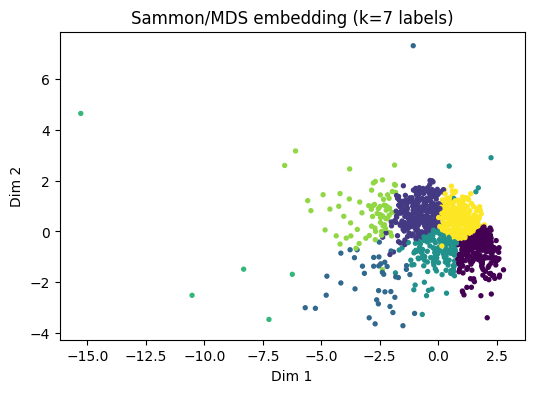

In [5]:

def sammon_embed(X):
    try:
        from sammon import sammon
        Y, E = sammon(X, 2)
        return np.array(Y)
    except Exception:
        mds = MDS(n_components=2, dissimilarity="euclidean", random_state=RNG)
        return mds.fit_transform(X)

X_vis = norm_standard_cluster.to_numpy(float)
Y2 = sammon_embed(X_vis)
_, y7 = kmeans_labels(X_vis, k=7)

plt.figure(figsize=(6, 4))
plt.scatter(Y2[:,0], Y2[:,1], s=8, c=y7)
plt.title("Sammon/MDS embedding (k=7 labels)")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.show()


c:\Users\steph\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


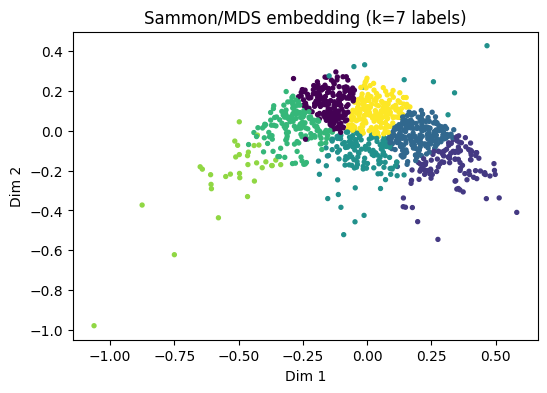

In [6]:

def sammon_embed(X):
    try:
        from sammon import sammon
        Y, E = sammon(X, 2)
        return np.array(Y)
    except Exception:
        mds = MDS(n_components=2, dissimilarity="euclidean", random_state=RNG)
        return mds.fit_transform(X)

X_vis = norm_minmax_cluster.to_numpy(float)
Y2 = sammon_embed(X_vis)
_, y7 = kmeans_labels(X_vis, k=7)

plt.figure(figsize=(6, 4))
plt.scatter(Y2[:,0], Y2[:,1], s=8, c=y7)
plt.title("Sammon/MDS embedding (k=7 labels)")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.show()


c:\Users\steph\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
C:\Users\steph\AppData\Local\Temp\ipykernel_6116\2676918959.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.xlabel("Dim 1"); plt.ylabel("Dim 2"); plt.legend()


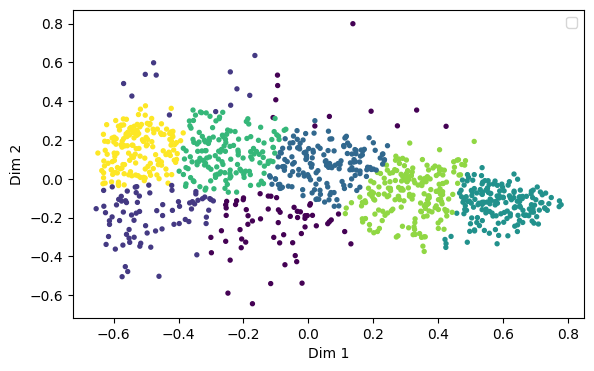

In [21]:

def sammon_embed(X):
    try:
        from sammon import sammon
        Y, E = sammon(X, 2)
        return np.array(Y)
    except Exception:
        mds = MDS(n_components=2, dissimilarity="euclidean", random_state=RNG)
        return mds.fit_transform(X)

X_vis = norm_euclidean_cluster.to_numpy(float)
Y2 = sammon_embed(X_vis)
_, y7 = kmeans_labels(X_vis, k=7)

plt.figure(figsize=(6.6, 4))
plt.scatter(Y2[:,0], Y2[:,1], s=8, c=y7)
plt.xlabel("Dim 1"); plt.ylabel("Dim 2"); plt.legend()
plt.savefig('../../LaTex/plots/e4_sammon.pdf', bbox_inches='tight')
plt.show()


### 2.4 Variable distributions by cluster

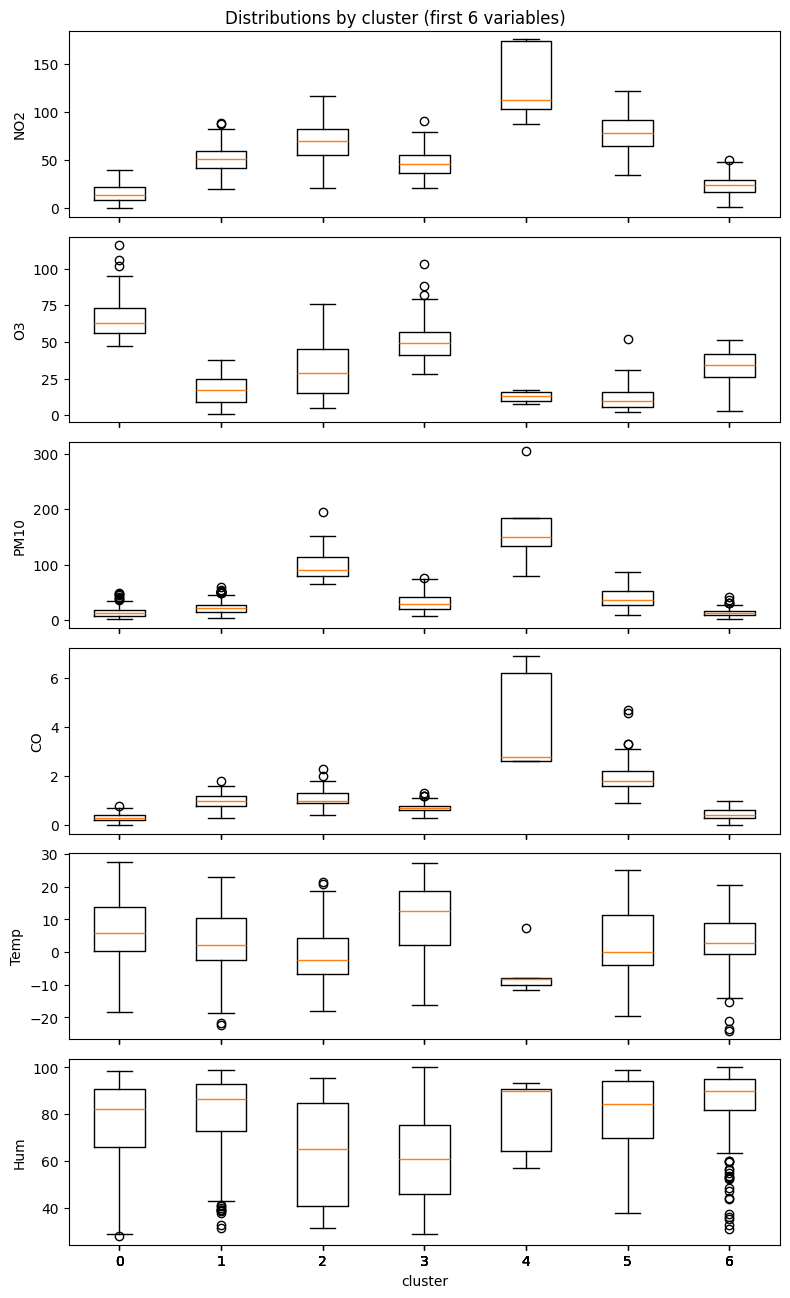

In [8]:
km7, y7 = kmeans_labels(norm_standard_cluster, k=7)
data_ext = sample_data_for_presentation.copy() # Create a copy
data_ext = data_ext.reset_index(drop=True) # Reset the index
data_ext["cluster"] = y7

cols = list(sample_data_for_presentation.columns)[:6]
n = len(cols)

fig, axes = plt.subplots(n, 1, figsize=(8, 2.2*n), sharex=True)
if n == 1:
    axes = [axes]
for ax, col in zip(axes, cols):
    groups = [data_ext.loc[data_ext["cluster"] == c, col].dropna().values for c in sorted(data_ext["cluster"].unique())]
    ax.boxplot(groups, tick_labels=sorted(data_ext["cluster"].unique()))
    ax.set_ylabel(col)
axes[-1].set_xlabel("cluster")
fig.suptitle("Distributions by cluster (first 6 variables)")
plt.tight_layout(); plt.show()

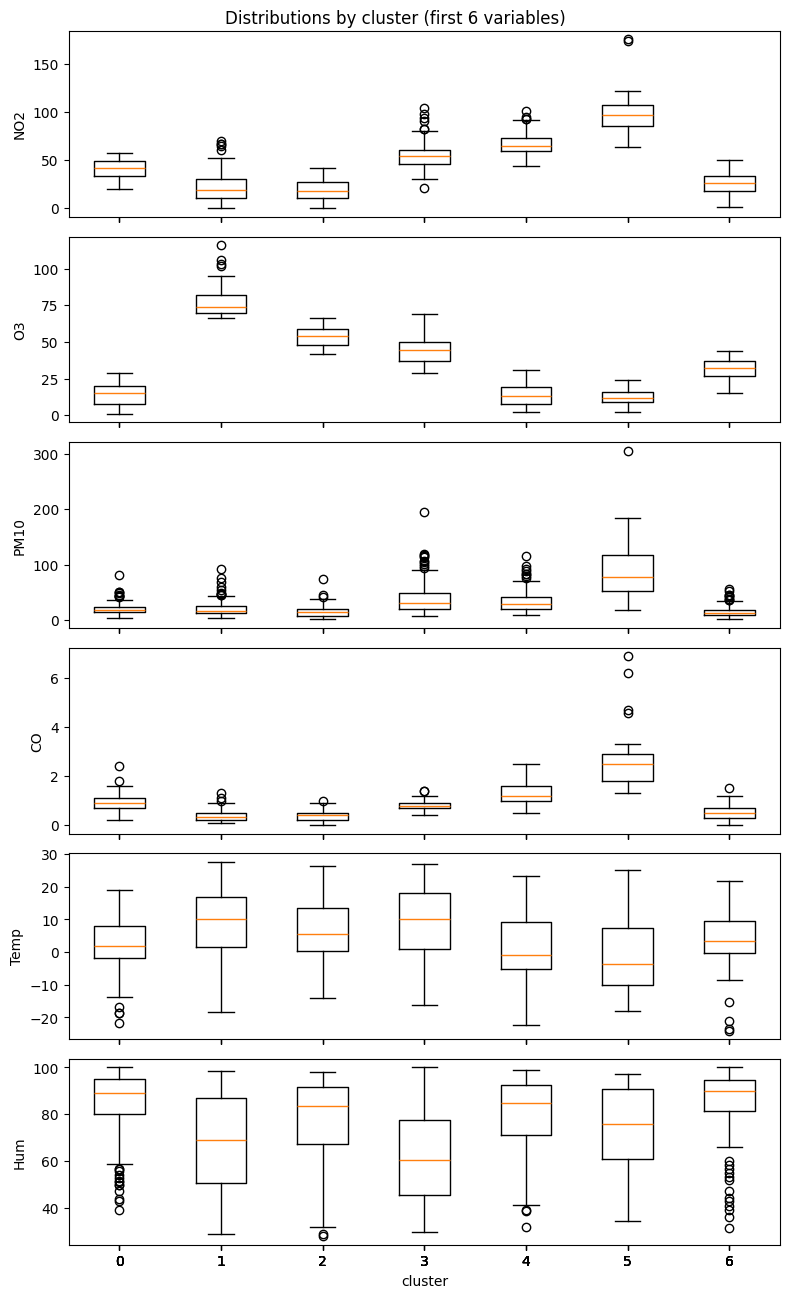

In [9]:
km7, y7 = kmeans_labels(norm_minmax_cluster, k=7)
data_ext = sample_data_for_presentation.copy() # Create a copy
data_ext = data_ext.reset_index(drop=True) # Reset the index
data_ext["cluster"] = y7

cols = list(sample_data_for_presentation.columns)[:6]
n = len(cols)

fig, axes = plt.subplots(n, 1, figsize=(8, 2.2*n), sharex=True)
if n == 1:
    axes = [axes]
for ax, col in zip(axes, cols):
    groups = [data_ext.loc[data_ext["cluster"] == c, col].dropna().values for c in sorted(data_ext["cluster"].unique())]
    ax.boxplot(groups, tick_labels=sorted(data_ext["cluster"].unique()))
    ax.set_ylabel(col)
axes[-1].set_xlabel("cluster")
fig.suptitle("Distributions by cluster (first 6 variables)")
plt.tight_layout(); plt.show()

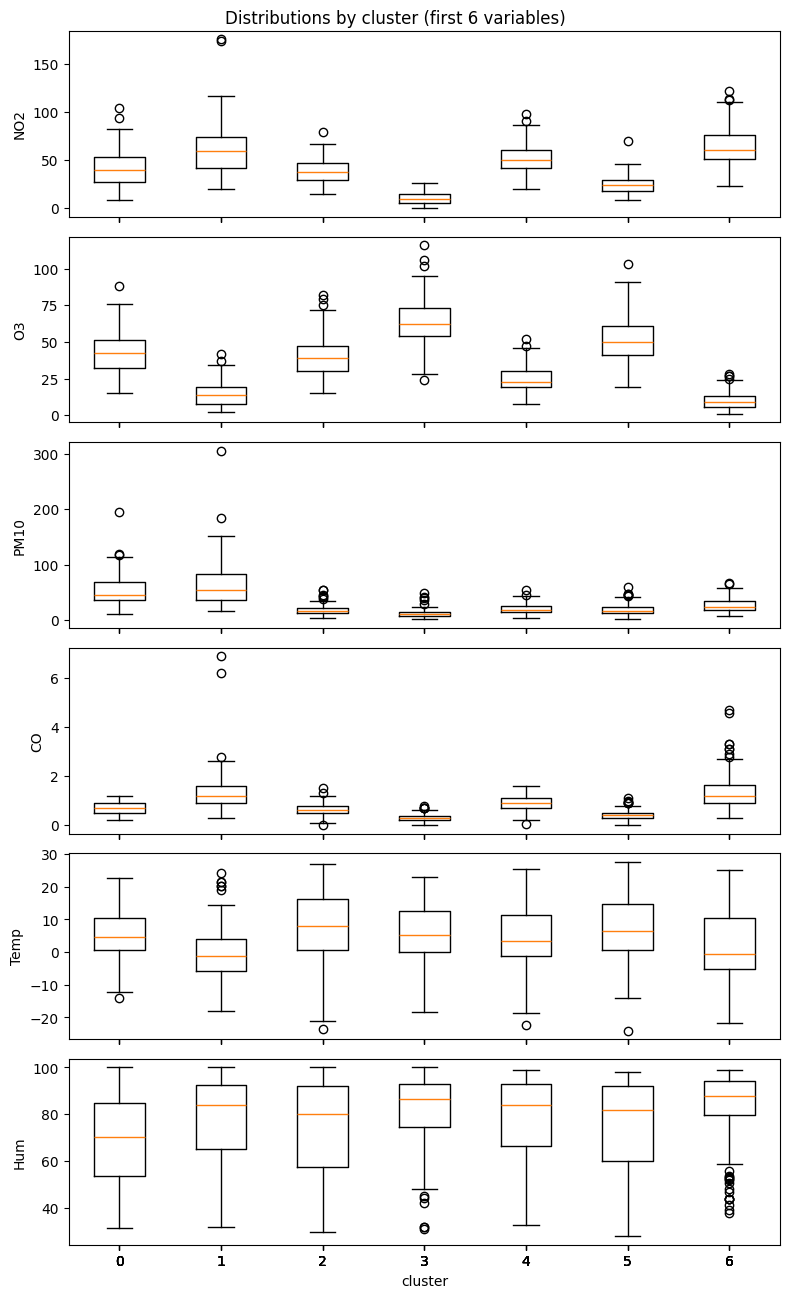

In [10]:
km7, y7 = kmeans_labels(norm_euclidean_cluster, k=7)
data_ext = sample_data_for_presentation.copy() # Create a copy
data_ext = data_ext.reset_index(drop=True) # Reset the index
data_ext["cluster"] = y7

cols = list(sample_data_for_presentation.columns)[:6]
n = len(cols)

fig, axes = plt.subplots(n, 1, figsize=(8, 2.2*n), sharex=True)
if n == 1:
    axes = [axes]
for ax, col in zip(axes, cols):
    groups = [data_ext.loc[data_ext["cluster"] == c, col].dropna().values for c in sorted(data_ext["cluster"].unique())]
    ax.boxplot(groups, tick_labels=sorted(data_ext["cluster"].unique()))
    ax.set_ylabel(col)
axes[-1].set_xlabel("cluster")
fig.suptitle("Distributions by cluster (first 6 variables)")
plt.tight_layout(); plt.show()

### 2.5 Silhouette plot (k=7)

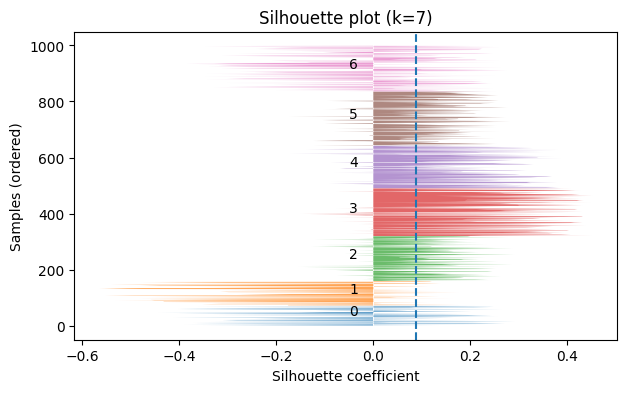

In [11]:

X = norm_standard_cluster.to_numpy(float)
labels = y7
sil_vals = silhouette_samples(X, labels)

order = np.argsort(labels)
labels_s = labels[order]
sil_s = sil_vals[order]

fig, ax = plt.subplots(figsize=(7, 4))
y_lower = 0
for c in np.unique(labels_s):
    sil_c = sil_s[labels_s == c]
    y_upper = y_lower + len(sil_c)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, sil_c, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * len(sil_c), str(c))
    y_lower = y_upper
ax.axvline(sil_vals.mean(), linestyle="--")
ax.set_xlabel("Silhouette coefficient")
ax.set_ylabel("Samples (ordered)")
ax.set_title("Silhouette plot (k=7)")
plt.show()


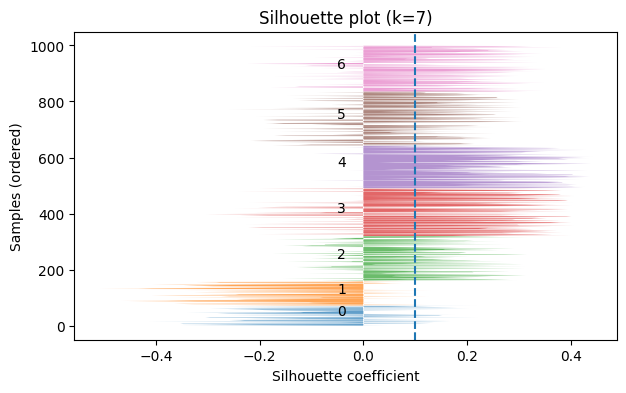

In [12]:

X = norm_minmax_cluster.to_numpy(float)
labels = y7
sil_vals = silhouette_samples(X, labels)

order = np.argsort(labels)
labels_s = labels[order]
sil_s = sil_vals[order]

fig, ax = plt.subplots(figsize=(7, 4))
y_lower = 0
for c in np.unique(labels_s):
    sil_c = sil_s[labels_s == c]
    y_upper = y_lower + len(sil_c)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, sil_c, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * len(sil_c), str(c))
    y_lower = y_upper
ax.axvline(sil_vals.mean(), linestyle="--")
ax.set_xlabel("Silhouette coefficient")
ax.set_ylabel("Samples (ordered)")
ax.set_title("Silhouette plot (k=7)")
plt.show()


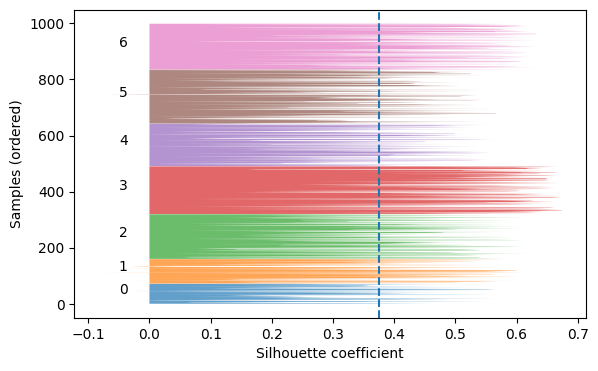

In [13]:

X = norm_euclidean_cluster.to_numpy(float)
labels = y7
sil_vals = silhouette_samples(X, labels)

order = np.argsort(labels)
labels_s = labels[order]
sil_s = sil_vals[order]

fig, ax = plt.subplots(figsize=(6.6, 4))
y_lower = 0
for c in np.unique(labels_s):
    sil_c = sil_s[labels_s == c]
    y_upper = y_lower + len(sil_c)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, sil_c, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * len(sil_c), str(c))
    y_lower = y_upper
ax.axvline(sil_vals.mean(), linestyle="--")
ax.set_xlabel("Silhouette coefficient")
ax.set_ylabel("Samples (ordered)")
plt.savefig('../../LaTex/plots/e4_silhouette.pdf', bbox_inches='tight')
plt.show()


## Questions — Task 1 (Transformations, k=7, Sammon/MDS, Distributions, Silhouette)

1. **Choice of transform.** Which transformation (standard, min–max, row‑L2) will you use going forward? Cite:  
   - one **visual** cue from the Sammon/MDS plot,  
   - one **distribution** difference visible in the boxplots, and  
   - one **metric** (Silhouette or DBI) number.
2. **Scale & outliers.** Which two variables in the *clustering set* are most likely to dominate Euclidean distance without scaling? Why?
3. **Separation.** From the **silhouette plot (k=7)**, which two clusters look least well‑separated? Point to (i) the silhouette bars and (ii) any overlap in distributions.
4. **Shape assumption.** Do the Sammon/MDS points suggest non‑spherical structure? If yes, explain what that implies for k‑means and whether a different method might be preferable.

I will use euclidean normalization. This is because
- The DBI number is lowest and the silhoutte number highest
- The goupings on the sammoon plot dont just lie in one corner (as with the others) but spread over the whole plane
- vizualizing the Silhoutte plot, little negative values and overlap
- The distributions of all clusters have similar spreads (boxplot)

I dont know about 2nd question

They look all quite well seperated. But maybe cluster 5 and 6. They seem to slightly overlap and be less separated

The clusters seem very spherical, i.e k-means is well suited. There are some outliers however.


## Task 2 — Optimize k via Davies–Bouldin

Sweep k=2..19 on your chosen transform, then decide on the final k.


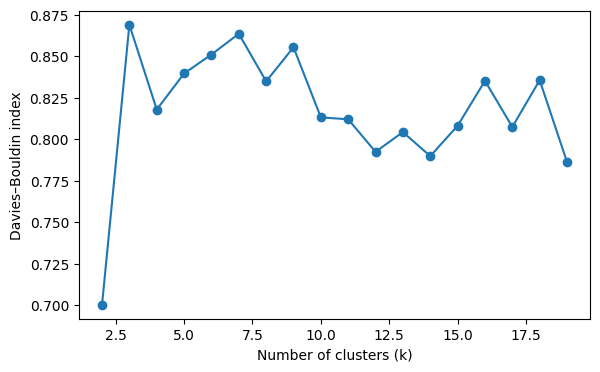


The optimal number of clusters (k) determined by minimizing the Davies-Bouldin Index is: 2


In [20]:

X_choice = norm_euclidean_cluster.to_numpy(float)
results = {}
for k in range(2, 20):
    km, lab = kmeans_labels(X_choice, k=k, n_init=30)
    dbi = davies_bouldin_score(X_choice, lab)
    results[k] = dbi

ks = sorted(results.keys())
vals = [results[k] for k in ks]

plt.figure(figsize=(6.6,4))
plt.plot(ks, vals, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Davies–Bouldin index")
plt.savefig('../../LaTex/plots/e4_dbi.pdf', bbox_inches='tight')
plt.show()

k_star = ks[int(np.argmin(vals))]
print(f"\nThe optimal number of clusters (k) determined by minimizing the Davies-Bouldin Index is: {k_star}")

## Questions — Task 2 (Model selection via DBI)

5. **Best k.** What value of **k** minimizes **DBI** (2–19)? Include the figure. If **Silhouette** prefers a different k, give two plausible reasons for the disagreement.
6. **Initialization sensitivity.** Re‑run k‑means for your chosen k with different `random_state` or `n_init` values (small experiment). Report the variation in **inertia**, **Silhouette**, or **DBI** and explain whether your choice of k is robust.

The best value of clusters seems to be the minimal of 2. This is stable over differernt n_ints but seems odd


## Task 3 — Time series per cluster


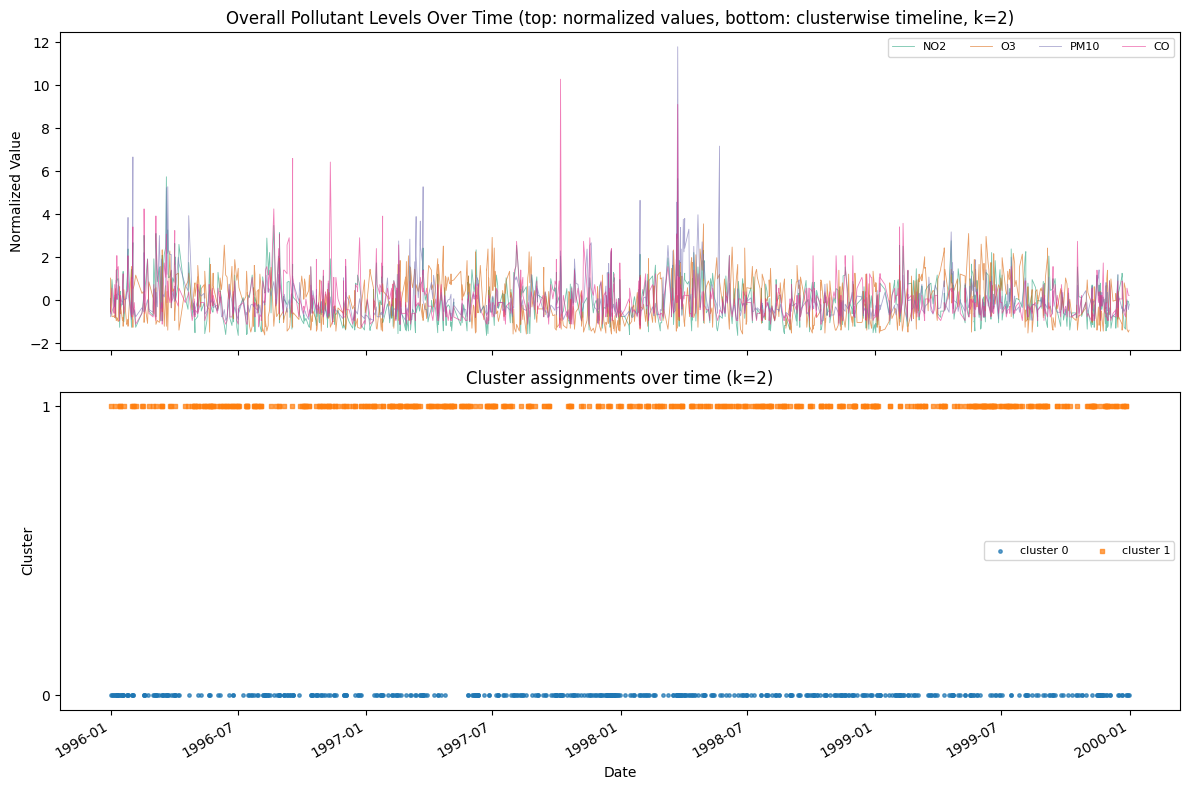

In [15]:
k_final = int(k_star)
km_final, labels_final = kmeans_labels(X_choice, k=k_final)

# Create a new DataFrame for plotting by copying the sampled data for presentation and resetting the index
processed_ext_corrected = sample_data_for_presentation.reset_index(drop=True).copy()

# Assign the cluster labels to the corrected DataFrame
processed_ext_corrected['cluster'] = labels_final

# Now, proceed with plotting the time series
time_cols = [c for c in processed_ext_corrected.columns if any(t in c.lower() for t in ["time", "date", "datetime"])]

# Check if 'Date' column exists and convert it to datetime, otherwise use the index
if 'Date' in data.columns:
    # Need to get the original Date column for the sampled data
    # Assuming the sampled data maintains the order of the original data after sorting by index
    x = pd.to_datetime(data.loc[sample_data_for_presentation.index, 'Date'], format='%Y%m%d', errors="coerce").reset_index(drop=True)
else:
    x = processed_ext_corrected.index

y_col = sample_data_for_clustering.columns[0] if len(sample_data_for_clustering.columns) > 0 else processed_ext_corrected.columns[0]

# Define cluster_col and other variables needed for the plot
cluster_col = "cluster"

# Apply StandardScaler to all pollutant variables for variance scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Get all pollutant columns from sample_data_for_clustering
pollutant_cols = sample_data_for_clustering.columns

# Store scaled values for each pollutant in processed_ext_corrected
for col in pollutant_cols:
    y = processed_ext_corrected[col].astype(float)
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()
    processed_ext_corrected[f"{col}_scaled"] = y_scaled

time_vals = np.asarray(x)
clusters = sorted(processed_ext_corrected[cluster_col].unique())

fig, (ax_ts, ax_cluster) = plt.subplots(
    2, 1,
    figsize=(12, 8),
    sharex=True,
    gridspec_kw={"height_ratios": [1, 1]} # Adjusted height ratio
)

# ===========================================================
# 1) Top subplot: overall variance-scaled time-series for all pollutants
# ===========================================================
import matplotlib # Import matplotlib explicitly to access colormaps
colors = matplotlib.colormaps.get_cmap('Dark2') # Changed colormap to 'Dark2'

for i, col in enumerate(pollutant_cols):
    ax_ts.plot(
        time_vals,
        processed_ext_corrected[f"{col}_scaled"],
        linewidth=0.6,
        alpha=0.6,
        color=colors(i),
        label=col # Add label for legend
    )

ax_ts.set_ylabel("Normalized Value") # Change label to reflect multiple variables
ax_ts.set_title(
    f"Overall Pollutant Levels Over Time (top: normalized values, "
    f"bottom: clusterwise timeline, k={k_final})"
)
ax_ts.legend(ncol=min(4, len(pollutant_cols)), fontsize=8) # Add legend for pollutants

# ===========================================================
# 2) Bottom subplot: clusterwise time-series (user requested format)
# ===========================================================
# Define a list of distinct markers
markers = ['o', 's', '^', 'D', 'p', 'h', '*', 'X', 'P', '+', 'v', '<', '>', 'd']

# Represent each observation as a point at (time, cluster_id)
for i, c in enumerate(clusters):
    m = processed_ext_corrected[cluster_col] == c # Use cluster_col
    x_c = time_vals[m] # Use time_vals for consistency

    # A scatter is clearer here than a line: each dot is an observation assigned to cluster c
    ax_cluster.scatter( # Use ax_cluster.scatter
        x_c,
        np.full_like(x_c, fill_value=c, dtype=float),
        s=6,
        alpha=0.7,
        label=f"cluster {c}",
        marker=markers[i % len(markers)] # Assign a different marker for each cluster
    )

ax_cluster.set_yticks(clusters) # Use ax_cluster.set_yticks
ax_cluster.set_ylabel("Cluster") # Use ax_cluster.set_ylabel
ax_cluster.set_xlabel("Date" if 'Date' in data.columns else "Index") # Use ax_cluster.set_xlabel
ax_cluster.set_title(f"Cluster assignments over time (k={k_final})") # Use ax_cluster.set_title
ax_cluster.legend(ncol=min(4, len(clusters)), fontsize=8) # Add legend

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

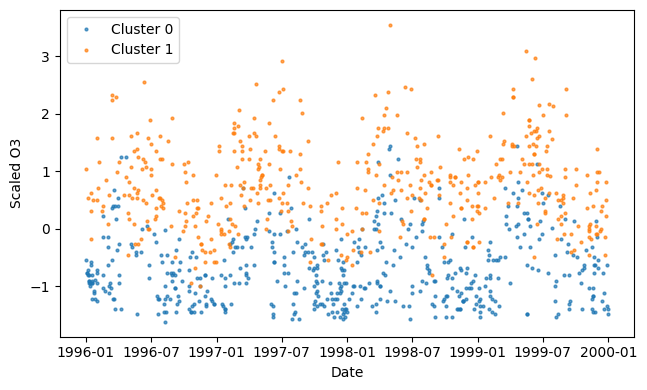

In [19]:
col = 'O3'
fig, ax = plt.subplots(figsize=(6.6, 4)) # Correctly assign fig and ax, add figsize

# Create masks for the two clusters (assuming k_final is 2 and clusters are 0 and 1)
mask_cluster_0 = (labels_final == 0)
mask_cluster_1 = (labels_final == 1)

# Plot for Cluster 0
ax.plot(time_vals[mask_cluster_0], processed_ext_corrected[f"{col}_scaled"][mask_cluster_0],
        label='Cluster 0', alpha=0.7, linestyle='None', marker='.', markersize=4)

# Plot for Cluster 1
ax.plot(time_vals[mask_cluster_1], processed_ext_corrected[f"{col}_scaled"][mask_cluster_1],
        label='Cluster 1', alpha=0.7, linestyle='None', marker='.', markersize=4)


ax.set_xlabel("Date")
ax.set_ylabel(f"Scaled {col}")
ax.legend()
plt.tight_layout()
fig.savefig('../../LaTex/plots/e4_timeseries.pdf', bbox_inches='tight')
plt.show()


## Questions — Task 3 (Time series by cluster)

7. **Temporal patterns.** Pick one pollutant and plot it over time colored by cluster. Do certain clusters align with known **episodes** or **seasons**? State a short hypothesis.
8. **Meteorology link.** Using the **presentation set**, do auxiliary variables (e.g., temperature, wind) differ significantly across clusters? Show one plot or simple statistic (mean/median) and interpret.


## Task 4 — Identify the clusters (write-up)

Fill 1–2 sentences per cluster describing pollutant levels, variability, and any temporal/meteorological pattern. Use distribution plots, silhouette, and time series as evidence.



## Questions — Task 4 (Interpretation)

9. **Cluster labels.** Provide a 1–2 sentence label for each cluster (e.g., *“High NO₂, moderate O₃; winter mornings; traffic‑dominated.”*).
10. **Actionable insight.** Propose one operational or policy action for the highest‑pollution cluster(s) (e.g., forecasting alerts, targeted mitigation). Justify briefly with evidence from your plots.
11. *(Optional)* **Feature wishlist.** Name one additional feature you would collect that could help separate confusing clusters, and say why.